# Karınca Kolonisi Optimizasyon Algoritması
​
Bu not defteri, Seyahat Eden Satıcı Sorununa uygulanan Karınca Kolonisi Optimizasyon Algoritması'nı açıklamaktadır. 
- https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms 
- https://en.wikipedia.org/wiki/Travelling_salesman_problem

Gezici Satıcı Nedir?
> Şehirlerin bir listesi ve her şehir çifti arasındaki mesafeler göz önüne alındığında, her şehri ziyaret eden ve ilk şehre geri dönen mümkün olan en kısa rota nedir?

Olası bir çözüm, bir Karınca Kolonisi'nden ilham alarak ve yiyecek bulmak için merkezi olmayan zekayı nasıl kullandığıdır:
- Koloni bir bütün olarak tek bir merkezi olmayan organizma olarak kabul edilebilir
  - Evrimsel olarak konuşursak, kraliçe tüm koloninin genetik bilgilerini taşır.
  - Bir insan vücudunda bireysel hücrelerle aynı rolü gerçekleştiren bireysel karıncalar olarak düşünülebilir.
- Karıncalar feromonları kullanarak iletişim kurar ve yürürken yanlarında bir feromon izi bırakırlar
- Yiyecek bulunmadığında ise, izci karıncalar rastgele yiyecek aramak için dolaşırlar.
- Bir izci karınca yiyecek bulduğunda, eve taşıyacak ve bu yönde yiyecek olduğuna dair bir feromon izi bırakacaktır.
- Böylece izci karınca, işçi karıncalarını, gıdaya geri takip etmesini teşvik edecektir.
- İşçi karıncaları genellikle en güçlü feromon izini takip eder, ancak bazen rastgele dolaşırlar.
- işçi karıncalar da arkalarında bir feromon izi bırakır ve bir yolu takip eden karıncalar ne kadar çok olursa, feromon izi o kadar güçlü olacaktır.
- Bir işçi karınca yiyecek bulduktan sonra, feromon izini dönüşüme uğratarak güçlendirir ve eve giden yol olduğu belli eder.
- Bir karınca yanlışlıkla daha kısa bir yol bulursa, gidiş dönüş süreleri uzun yoldan daha kısa olacaktır, daha fazla gidiş dönüş daha fazla feromon anlamına gelir.
- Daha kısa yol boyunca feromonlar daha uzun yoldan daha hızlı bir şekilde biriktiğinden, daha fazla karıncayı bu yolu keşfetmeye teşvik edecek ve feromonları daha da hızlı bir şekilde oluşturacaktır.
- Sonunda feromon izleri ağı, yiyecek konumları arasındaki en kısa yollar için neredeyse en uygun çözümlerin haritasını çıkarır
- Yiyecek bittiğinde ise, karıncalar izci olarak dağılacak ve eski feromon izleri kaybolacaktır. Böylece yol unutulur.
- Bununla birlikte, karıncalar dikkatli değilse, hepsi bir daire içinde birbirini takip eden ancak bir yere gitmeyen bir ölüm çemberine düşmeleri de ihtimaller arasındadır.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/images/united_states_map.png


# Harita

### İlk önce bir şehir haritası tanımlayalım

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt #Görselleştirme İçin kütüphane
import matplotlib.image as mpimg #Resmi dahil etmek için kütüphane

united_states_map = mpimg.imread("/kaggle/input/images/united_states_map.png")
def show_cities(path, w=12, h=8):
    """ABD Devletleri ve başkentlerinin haritasında yer alan bir TSP yolu çizme işlemi."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'r.', markersize=15)  # y* = Başlangıç noktası için sarı yıldız
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8, linestyle='--'):
    """ABD Devletleri ve başkentlerinin haritasında yer alan bir TSP yolu çizme işlemi."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = Başlangıç noktası için sarı yıldız
    plt.plot(x + x[:1], y + y[:1],linestyle='--',linewidth=1.75)  # Yolun sonundaki başlangıç noktasını ekleme
    plt.legend()
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "+", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))    
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Şehir Adı", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Şehir Adı": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Şehir Adı", (x,y))
    return int(sum( #Dönüş Yolunun başlangıç toplamı
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # Dönüş yolculuğunun maliyetini dahil etme
    ))

In [3]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Şehir Adı", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Şehir Adı": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Şehir Adı", (x,y))
    return int(sum( #Dönüş Yolunun başlangıç toplamı
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # Dönüş yolculuğunun maliyetini dahil etme
    ))

# Eyaletlerin İşaretlenmesi

14


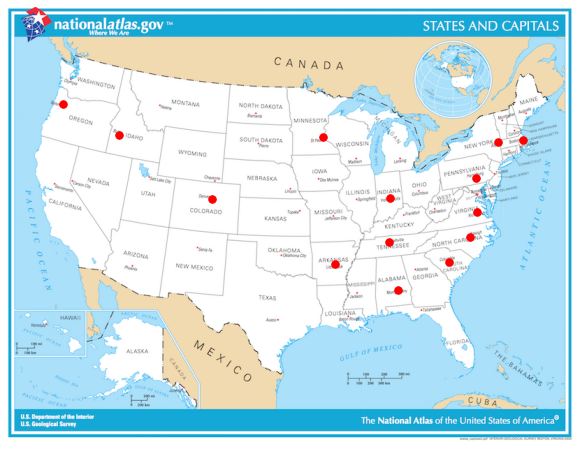

In [4]:
cities = {"Montgomery": (559.6, 404.8), "Saint Paul": (451.6, 186.0),  "Salem": (80.0, 139.2), "Little Rock": (469.2, 367.2), "Richmond": (673.2, 293.6), "Denver": (293.6, 274.0), "Boise": (159.6, 182.8), "Raleigh": (662.0, 328.8), "Indianapolis": (548.0, 272.8), "Nashville": (546.4, 336.8), "Columbia": (632.4, 364.8), "Boston": (738.4, 190.8), "Albany": (702.0, 193.6), "Harrisburg": (670.8, 244.0) }
cities = list(sorted(cities.items()))
print(len(cities))
show_cities(cities)

3868

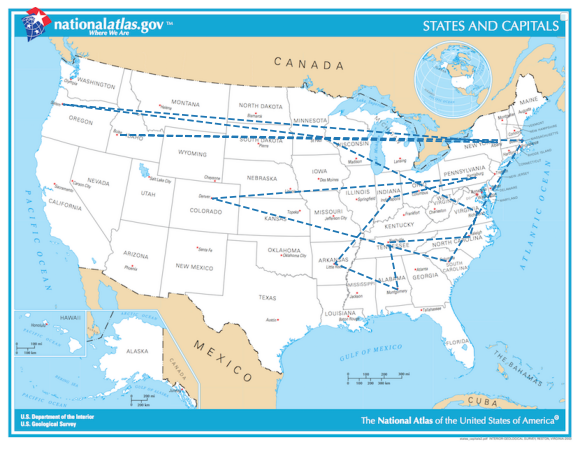

In [5]:
show_path(cities) #Şehirleri yol çizdirme
path_distance(cities) #Kaç farklı yol 

# Karınca Kolonisi

- Performans nedenleriyle, karıncalar hızlı vektörize işlemlere izin veren 2048 geniş numpy dizileri kümesi olarak temsil edilir
- Parametrelerin çoğu, karınca kolonisinin iç mantığını etkileyecek,mantıklı / optimum varsayılanlara ayarlanmıştır.
- Algoritmanın tam manasıyla açıklanması
    - Karıncaları rastgele bir yürüyüşe çıkarıyoruz, her biri ayrı ayrı Seyahat Eden Gezgin Satıcı rolünü üstlenmektedir
        - `ant_count` Numpy dizisindeki karıncaların sayısını tanımlar.
        - `ant_speed` Her karıncanın seyehat(Keşif) sürecinde kaç adım attığını tanımlar
    - Karıncalar ayrı ayrı şunları izlemektedir: 
        - `path` Daha önce ziyaret ettikleri şehirlerin listesi
        - the set of `remaining` Hala ziyaret etmeleri gereken şehirler
        - `distance` Bulunduğu yerden bir sonraki hedeflerine
        - `path_cost` Kaç adım attıkları
        - `round_trips` Koloni ile toplu bir şekilde tekrardan kat edilen yol       
    - Karıncalar seyahat ettiğinde, Vectorized bir geri sayım var. `distance`
    - Bir karınca bir düğüme ulaştığında:(Bu probleme göre bir işaretçiye ulaştığında)
        - Kalan listesinde rastgele yeni bir hedef seçer ==>`remaining`
        - Seçimi, diğer karıncalar tarafından bırakılan feromonların miktarı ile ağırlıklandırılır
        - `pheromone_power` Karıncaların feromonlardaki küçük farklılıklardan ne kadar güçlü etkilendiğini belirtir
        - `distance_power`  Karıncaların mesafe farkındalığını etkiler, yani önce daha yakın düğümleri ziyaret etme tercihidir
        - `reward_power`    Yeni feromon izleri bırakılırken 'best_path/current_path' nasıl kullanıldığını etkiler
            - `** -3` En iyi yol ve doğru yol seçimi için en az seçilen sayıdır
            - Karıncaları en güçlü feromon yolunun etrafında daha uzun yolları keşfetmeye teşvik eder
        - `decay_power`  Eski feromon izlerinin ne kadar çabuk çürüdüğünü etkiler
        - Bir karınca listesindeki tüm düğümleri ziyaret ettiğinde, eve döner 
    - Bir karınca eve döndüğünde::
        - Tamamladığı yolu için "self.pheromon" haritasını güncelleyerek diğerlerine bu yolun popüler olduğunu söyler.
        - "self.round_trips" ile eski feromon izlerini yavaşça bozar ve kaybeder
        - self.ants_used` sayısını günceller.     
        - Karınca bireysel "self.round_trips" sayısını günceller.
        - Karınca sıfırlanır ve Seyahat Eden Satıcı Problemini yeniden başlatır
    - Eğer karınca şimdiye kadar en iyi yolu bulursa:
        - En iyi yolun kaydını tutar ve kraliçeyi bilgilendirir
        - Kraliçe, bu yeni en iyi yol boyunca feromonları ikiye katlar, bu da karıncaların bu yolu keşfetme olasılığını ikiye katlamış olur.
        - `best_path_smell` Yeni bir en iyi yol bulunduğunda kraliçenin kullandığı fermon çarpanını kontrol eder.
    - Seyehat Sonlandırma: Yapılandırılabilir birkaç seçenek var:
        - `self.stop_factor`  Karınca Mantığı: Eğer yeni bir en iyi yol bulunduysa, yol arayışını bırakmadan önce yeni çabaları iki katına çıkarır.
            - 2 çarpanı, son en iyi yolu bulmak için gereken sürenin iki katı olacaktır
            - Bazı durumlarda erken sonlandırmayı önlemede 4 faktörü daha güvenilirdir (ancak çok zaman alabilir)
        - `self.time`          Sabit bir saniye kadar koş ve sonra dur
        - `self.min_time`      Doğal olarak sonlandırmadan önce minimum birkaç saniye çalıştırma
        - `self.timeout`       Maksimum saniye boyunca çalıştırın, ancak önceden doğal olarak sonlandırılabilir
        - `self.round_trips`   Sonlandırmaya karşı ön koşul olarak minimum sayıda round_trips'i bekleyin (varsayılan 4)
        

In [6]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]], #Parametreler                         
                 
                 time=0,                  # Sabit bir süre için çalıştırma
                 min_time=0,              # Minimum çalışma zamanı
                 timeout=0,               # Maxiumum çalışma zamanı
                 stop_factor=2,           # Yeni en iyi yeni yoldan sonra çabayı kaç kez tekrarlama
                 min_round_trips=10,      # Seyehat sonlandırmadan önceki minumum gidiş dönüş sayısı
                 max_round_trips=0,       # Seyehat sonlandırmadan önceki maximum gidiş dönüş sayısı               
                 min_ants=0,              # Kullanılacak toplam karınca sayısı
                 max_ants=0,              # Kullanılacak toplam karınca sayısı
                 
                 ant_count=64,            # Numpy performansı için en uygun aralığın alt kısmıdır
                 ant_speed=1,             # Karıncaların seyehat başına adım hızı

                 distance_power=1,        # Mesafenin feromonları etkilediği güç                
                 pheromone_power=1.25,    # Feromonlardaki farklılıkların fark edildiği güç
                 decay_power=0,           # Feromonlar ne kadar hızlı çürüdüğü
                 reward_power=0,          # best_path_length/path_length arasında ki göreceli karşılık(Sonuç) 
                 best_path_smell=2,       # Yeni en iyi yeni yolu bulduktan sonra kraliçenin feromon koku artırma                 
                 start_smell=0,           # Başlangıç feromonlarının miktarı [0 varsayılan olarak `10**self.distance_power`]

                 verbose=False, #Verbose True olursa işlemleri gösterir

    ):
        assert callable(cost_fn)        #Yukarıda tanımladığımız cost maskesini giydiriyoruz 
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Düğümler arasındaki mesafelerin önbelleği
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Düğümler arasındaki mesafe maliyetlerinin önbelleğe alınması-sıkı bir döngüde bölünme pahalıdır
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Bu, yavaş yavaş biriken feromon izini saklar
        self.pheromones = {
            source: {
                # Karıncaları her yönden ve en uzak noktadan keşfetmeye teşvik 
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Giriş parametrelerini gözden geçirilmesi etmek
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Sezgisel İhracat
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Karıncaların eve dönüşü!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Karıncaların Vectorized Yürüyüş
            # Küçük bir optimazsyon ayarlaması `> self.ant_speed` 'den '`> 0` ants_arriving 
                    #### Karıncanın adım sayısını seyahetten uzun tutmamak####
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # bir sonraki karınca gelene kadar sonlandırma kontrollerini atla
            
            ### Karıncaların Vectorized kontrolü
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### Bir sonra ki karıncanın next_node'den gelmesi
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### Karınca koloniye geri döndü
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### Yeni bir en iyi yol bulunması ve - Kraliçeyi bilgilendirinme
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "Yol_Maliyeti":   int(ants['path_cost'][i]),
                                "Karınca_Sayısı":   self.ants_used,
                                "Seyehat_Sayısı":       epoch,
                                "Tur_Sayısı": ants['round_trips'][i] + 1,
                                "Zaman":       int(time.perf_counter() - time_start),
                            })
### Feromon izinin bırakılması
#  * self.round_trips ==> Eski feromon izlerini bozma etkisine sahiptir
# ** self.reward_power = -3, karıncaları daha uzun yolları keşfetmeye teşvik etme etkisine sahiptir
#                      en iyi yol ile birlikte feromon izlerini iki katına çıkarır
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Kraliçe, bu yeni en iyi yolu takip eden karıncaların sayısını iki katına çıkarmayı emrediyor                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### Evde ki karıncanın sıfırlanması
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Seyehat sonlandırma işlemi 
            
            # Her zaman en az 1 çözüm bekleyin (not: 2'den fazla çözüm garanti edilmez)
            if not len(best_epochs): continue 
            
            # Zamanlayıcı diğer kısıtlamalara göre önceliklidir
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
# İlk seyahtte sadece başlangıç kokusu vardır 
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # Bu faktör en çok hesaplama gücüne bağlıdır          
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Daha fazlasını bulamayana kadar çabalarımızı ikiye katlamaya devam edelim
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Bizi başka hiçbir şey durduramaz: Kraliçe karıncalara devam etmelerini emreder!
            if True: continue
            
            
            
        ### En uyguna yakın bir yol bulduk, Kraliçe'ye rapor verdik.
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Daha kısa yolları tercih edin
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Karıncalar yollarda ki feromon ağrılıklarıyla rast gele yol seçer
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs,):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("Sehir_Sayısı={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | Karıncalar: {:5d} | Seyahatler: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

# Seyahat eden satıcı problemi

Karıncaların ilk turu hızlı bir şekilde makul bir yol bulur, daha sonra koloni hızlı bir şekilde optimal olmayan bir yolda birleşir
- Herhangi bir zamanda Seyahat eden 1024 karıncalar vardır
- Karıncalar feromon izlerini takip eder ve oluştururlar, ancak gidecek bir sonraki şehri belirlemek için '1/mesafe' ölçümü de kullanırlar.
- Başlangıçta karıncalar "1/distance ^ 2" sezgisel kullanıyordu, ancak hiperparametre ayarlamasından sonra, "1/distance" nin eşdeğer sonuçlar üretebileceği keşfedildi (şimdi varsayılan)
- Karıncalar artık daha iyi bir yol bulamayana kadar çabalarını tekrar tutmaya devam edecek

{'Yol_Maliyeti': 2130, 'Karınca_Sayısı': 1, 'Seyehat_Sayısı': 1716, 'Tur_Sayısı': 1, 'Zaman': 0}
{'Yol_Maliyeti': 1973, 'Karınca_Sayısı': 68, 'Seyehat_Sayısı': 4072, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 1821, 'Karınca_Sayısı': 95, 'Seyehat_Sayısı': 4753, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 1749, 'Karınca_Sayısı': 140, 'Seyehat_Sayısı': 6193, 'Tur_Sayısı': 3, 'Zaman': 0}
{'Yol_Maliyeti': 1724, 'Karınca_Sayısı': 285, 'Seyehat_Sayısı': 10178, 'Tur_Sayısı': 5, 'Zaman': 0}
{'Yol_Maliyeti': 1665, 'Karınca_Sayısı': 339, 'Seyehat_Sayısı': 11627, 'Tur_Sayısı': 6, 'Zaman': 0}
{'Yol_Maliyeti': 1613, 'Karınca_Sayısı': 662, 'Seyehat_Sayısı': 19278, 'Tur_Sayısı': 11, 'Zaman': 0}
Sehir_Sayısı=14  |  3868 -> 1620 |    1s | Karıncalar:  1514 | Seyahatler:   25 | distance_power=1


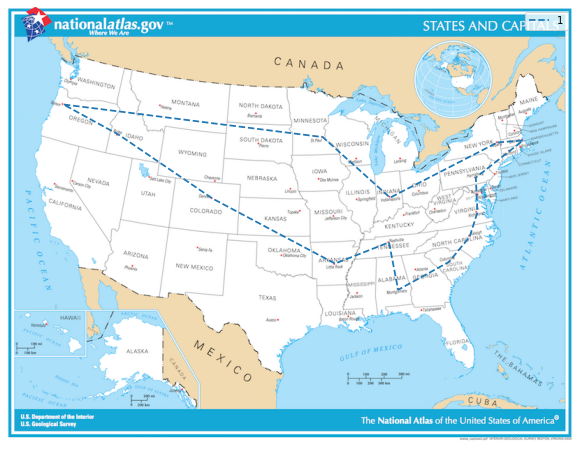

In [7]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)
plt.legend('1');

# Algoritmaya Göre Eğitilmemiş Karıncalar
​
> Elbette bu karıncalar aldatıyor. Mesafeleri görebiliyorlar ve güçlü bir şekilde kareler olarak öğretilmişler, daha yakın düğümleri ziyaret etmeyi tercih ediyorlar. Vahşi doğada, karıncalar feromon izi dışındaki her şeye kör olurlar, bu yüzden bunun algoritmayı nasıl etkilediğini görelim.
​
- Karıncalar yavaş ama metodik olarak daha iyi çözümler üzerinde birleşirler
- Bulunan son yol(mesafe)^2 karınca mesafesinden %30 daha uzundur 
- Geri dönen ilk karınca, mesafenin neredeyse iki katı uzunluğunda bir yol(mesafe)^2 aldı 
- Algoritma, 6x çalışma süresiyle hesaplama açısından çok daha uzundu 
- Ortaya çıkan grafik, erken keşif sırasında bulunan ana yolları temsil ettiği için daha fazla döngü ve keskin köşeler içerir.
- Bulunan yol, mükemmel olmasa da, vahşi karıncaların açlıktan ölmesini önlemek için hala yeterlidir
  bazen bu erken sonlandırmadan muzdariptir, bu nedenle bunu önlemek için başka bir sonlandırma koşulu gereklidir 
                                           ==>min_ants==< 

{'Yol_Maliyeti': 2786, 'Karınca_Sayısı': 1, 'Seyehat_Sayısı': 2577, 'Tur_Sayısı': 1, 'Zaman': 0}
{'Yol_Maliyeti': 2694, 'Karınca_Sayısı': 65, 'Seyehat_Sayısı': 5438, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 2620, 'Karınca_Sayısı': 131, 'Seyehat_Sayısı': 8660, 'Tur_Sayısı': 3, 'Zaman': 0}
{'Yol_Maliyeti': 2532, 'Karınca_Sayısı': 135, 'Seyehat_Sayısı': 9054, 'Tur_Sayısı': 3, 'Zaman': 0}
{'Yol_Maliyeti': 2103, 'Karınca_Sayısı': 140, 'Seyehat_Sayısı': 9415, 'Tur_Sayısı': 3, 'Zaman': 0}
{'Yol_Maliyeti': 2074, 'Karınca_Sayısı': 199, 'Seyehat_Sayısı': 11710, 'Tur_Sayısı': 4, 'Zaman': 0}
{'Yol_Maliyeti': 1822, 'Karınca_Sayısı': 293, 'Seyehat_Sayısı': 15685, 'Tur_Sayısı': 6, 'Zaman': 0}
{'Yol_Maliyeti': 1795, 'Karınca_Sayısı': 412, 'Seyehat_Sayısı': 20206, 'Tur_Sayısı': 8, 'Zaman': 0}
{'Yol_Maliyeti': 1770, 'Karınca_Sayısı': 447, 'Seyehat_Sayısı': 21410, 'Tur_Sayısı': 8, 'Zaman': 0}
{'Yol_Maliyeti': 1724, 'Karınca_Sayısı': 582, 'Seyehat_Sayısı': 25669, 'Tur_Sayısı': 10, 'Zaman': 0}
{'Yol_M

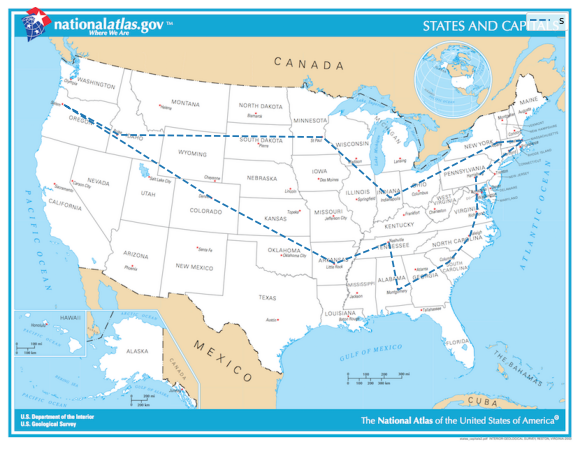

In [8]:
results = AntColonyRunner(cities, distance_power=0, stop_factor=1.25, verbose=True, plot=True)
plt.legend('s');

### Yukarıda ki görselde görüldüğü gibi, Erken seyahat sonlandırma işlemi aynı yerden bir kaç defa daha gidildiğini göstermektedir. Sonucumuzu tekrardan çalışma süresini ve Mesafenin feromonları etkilediği güc değerlerini değiştirelim

{'Yol_Maliyeti': 2287, 'Karınca_Sayısı': 1, 'Seyehat_Sayısı': 1873, 'Tur_Sayısı': 1, 'Zaman': 0}
{'Yol_Maliyeti': 2222, 'Karınca_Sayısı': 6, 'Seyehat_Sayısı': 1974, 'Tur_Sayısı': 1, 'Zaman': 0}
{'Yol_Maliyeti': 2182, 'Karınca_Sayısı': 7, 'Seyehat_Sayısı': 2011, 'Tur_Sayısı': 1, 'Zaman': 0}
{'Yol_Maliyeti': 2015, 'Karınca_Sayısı': 65, 'Seyehat_Sayısı': 3696, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 1973, 'Karınca_Sayısı': 67, 'Seyehat_Sayısı': 3776, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 1669, 'Karınca_Sayısı': 69, 'Seyehat_Sayısı': 3782, 'Tur_Sayısı': 2, 'Zaman': 0}
{'Yol_Maliyeti': 1621, 'Karınca_Sayısı': 338, 'Seyehat_Sayısı': 10803, 'Tur_Sayısı': 6, 'Zaman': 0}
Sehir_Sayısı=14  |  3868 -> 1628 |    0s | Karıncalar:   533 | Seyahatler:   10 | distance_power=1 stop_factor=1.25


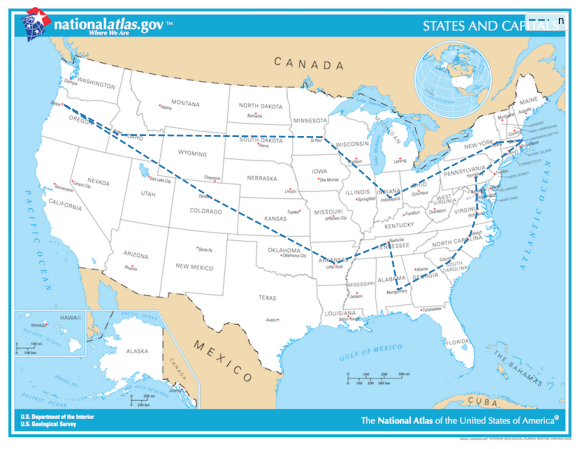

In [9]:
result = AntColonyRunner(cities, distance_power=1, stop_factor=1.25, verbose=True, plot=True)
plt.legend("n");

### Değiştirilen parametrelerle gidiş ve dönüş yolları arasında tekrarlama ortadan kaldırılmıştır

# İstatistiksel Rastgele Varyasyon
​
Karınca Kolonisi Optimizasyon Algoritması, en uygun yolu bulmaya izin vermemesi anlamında "tam" olmasa da, birçok kullanım durumu için kabul edilebilir olabilecek optimal bir yola hızla yakınlaşabilir.
​
Stokastik/rastgele==>(Kesin olmayan) bir model içerir,ancak istatistiksel bir analiz şunları gösterir:
​
​
- Yakınsanmış sonuçlar için:
  - Standart sapma 17,2'dir, bu da ortalama yol uzunluğunun yaklaşık% 1'idir 
  - Maksimum ve minimum yol uzunluğu arasındaki fark 58'dir 
> Statik analizlerde çıkan sonucun doğruluğunun kabul edilebilir olması için kullanılan ifadedir.  
  
- Sabit bir 10s zamanlayıcıda çalıştırma:
  - Standart sapma biraz azaltılarak  düşürülür
  - Ortalama yol uzunluğu, yakınsak sonuçlardan daha yüksektir
  
Bu, algoritmanın makul ölçüde tutarlı olduğunu ve erken sonlandırma ile hala kabul edilebilir sonuçlar üretebileceğini gösterir. 

In [10]:
results_converged = [ AntColonyRunner(cities) for i in range(10) ]

Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   836 | Seyahatler:   14 | 
Sehir_Sayısı=14  |  3868 -> 1620 |    1s | Karıncalar:  1728 | Seyahatler:   28 | 
Sehir_Sayısı=14  |  3868 -> 1657 |    0s | Karıncalar:  1119 | Seyahatler:   19 | 
Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:  1177 | Seyahatler:   19 | 
Sehir_Sayısı=14  |  3868 -> 1710 |    0s | Karıncalar:   559 | Seyahatler:   10 | 
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   684 | Seyahatler:   12 | 
Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:   662 | Seyahatler:   11 | 
Sehir_Sayısı=14  |  3868 -> 1620 |    1s | Karıncalar:  1364 | Seyahatler:   22 | 
Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:   616 | Seyahatler:   10 | 
Sehir_Sayısı=14  |  3868 -> 1657 |    0s | Karıncalar:   835 | Seyahatler:   14 | 


#### Yakınsanmış sonuçlar için şehir bazında 10 farklı değerde çalıştırıldığında sonuçlar yukarıdaki gibidir

In [11]:
results_timed = [ AntColonyRunner(cities, time=10) for i in range(10) ]

Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 26867 | Seyahatler:  424 | time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 29418 | Seyahatler:  463 | time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 27398 | Seyahatler:  435 | time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 28373 | Seyahatler:  450 | time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 29164 | Seyahatler:  458 | time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 28741 | Seyahatler:  454 | time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 29310 | Seyahatler:  465 | time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 29347 | Seyahatler:  461 | time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 27069 | Seyahatler:  428 | time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 28677 | Seyahatler:  451 | time=10


In [12]:
import pandas as pd
results_converged_stats = pd.Series([ path_distance(path) for path in results_converged ]).describe()
results_timed_stats     = pd.Series([ path_distance(path) for path in results_timed     ]).describe()
pd.DataFrame({
    "results_converged": results_converged_stats,
    "results_timed":     results_timed_stats,
    "difference":        results_converged_stats - results_timed_stats,
}).T.round(1)

count    mean   std     min     25%     50%     75%     max
results_converged   10.0  1635.8  30.5  1618.0  1618.5  1620.0  1647.8  1710.0
results_timed       10.0  1618.8   1.0  1618.0  1618.0  1618.0  1620.0  1620.0
difference           0.0    17.0  29.4     0.0     0.5     2.0    27.8    90.0

# Hiperparametrelerle Algoritmamızı Optimize Edelim
> Algoritamanın ayarlanabilir parametreleriyle eğitilerek yolun daha kısa olması ve doğru olması beklenir

Ayarlanabilen bir dizi hiperparametre vardır:
```
- ant_count=2048,          # İyi bir performans için en uygun sayıya yakındır.
- ant_speed=1,             # Karıncalar seyehat başına kaç adım gider.
- start_smell=0,           # Başlangıç feromonlarının miktarı [0 varsayılan için `10**self.distance_power`]
- best_path_smell=2,       # Yeni bir en iyi yol bulduktan sonra Feromonların artırımı için kraliçe çarpanı
- reward_power=-3,         # Sezgizel olarak 3 değeridir. Ancak daha fazla keşif yolları açmaktadır(Ödüllendirme)
- distance_power=2,        # Mesafenin feromonları etkilediği güçtür
- pheromone_power=1,       # Feromonlardaki farklılıkların fark edildiği güçtür.(Güç artırılırsa keşif artar,işlem uzar)
- decay_power=1,           # Feromon izlerinin ne kadar hızlı bozulduğudur.

## Karınca Sayısı Optimizasyonu    
> |ant_count

Bu, vektörize edilmiş numpy dizileri ve python döngüleri kullanmanın performansa etkisini gerçekten gösterir.
- Üretilen karıncaların sayısını gözlem yapar
- Numpy dizilerdeki işlemlerin doğrusal bir ek yükü vardır.(Daha fazla karıncanın numpy dizilerini yorması)
- Küçük olan dizileri (4 veya daha küçük), python temellerini kullanmaktan çok daha yavaş olabilir
- Numpy dizilerinin en uygun boyutu 256-4096 noktadır.
- 64-16384 hala optimuma yakın performans sağlar.
- 32768+, performansta belirgin bir düşüşe neden olur - çok küçük diziler kullanmak kadar kötü duruma dönüşebilir.

Sehir_Sayısı=14  |  3868 -> 1642 |   60s | Karıncalar:  8277 | Seyahatler: 8277 | ant_count=1 time=60
Sehir_Sayısı=14  |  3868 -> 1628 |   60s | Karıncalar: 14582 | Seyahatler: 7294 | ant_count=2 time=60
Sehir_Sayısı=14  |  3868 -> 1620 |   60s | Karıncalar: 26220 | Seyahatler: 6571 | ant_count=4 time=60
Sehir_Sayısı=14  |  3868 -> 1618 |   60s | Karıncalar: 47998 | Seyahatler: 6006 | ant_count=8 time=60
Sehir_Sayısı=14  |  3868 -> 1626 |   60s | Karıncalar: 73295 | Seyahatler: 4591 | ant_count=16 time=60
Sehir_Sayısı=14  |  3868 -> 1620 |   60s | Karıncalar: 120439 | Seyahatler: 3772 | ant_count=32 time=60
Sehir_Sayısı=14  |  3868 -> 1620 |   60s | Karıncalar: 143641 | Seyahatler: 2249 | ant_count=64 time=60
Sehir_Sayısı=14  |  3868 -> 1618 |   60s | Karıncalar: 194528 | Seyahatler: 1533 | ant_count=128 time=60
Sehir_Sayısı=14  |  3868 -> 1618 |   60s | Karıncalar: 226127 | Seyahatler:  890 | ant_count=256 time=60
Sehir_Sayısı=14  |  3868 -> 1618 |   60s | Karıncalar: 218596 | Seyahat

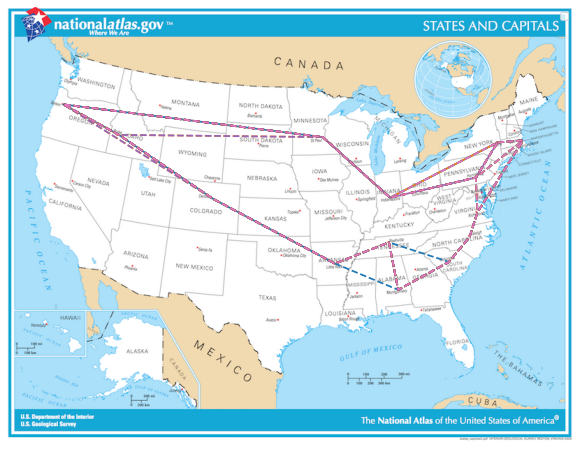

In [13]:
for ant_count in range(0,16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60,plot=True)

### Karınca Bazında Eğitildiğinde Karınca Sayısında Artış, Dönüşte ise azalış olması beklenmektedir

# Minimum ve Maksimum Karınca Optimizasyonu
> |min_ants

Çözülmemiş ana problemlerden biri, algoritmanın performansının nasıl optimize edileceğidir ve aynı zamanda yakınsamayı doğru şekilde tespit etmesidir.
​
- Düşük bir ant_count, saniyede daha fazla gidiş dönüş anlamına gelir
    - Feromon izinin daha iyi kullanılmasını sağlar.
    - Aynı zamanda Erken seyahat sonlandırma işlemi riskini de arttırır 
- Çok yüksek karınca sayısı ise;
    - Erken seyahat sonlandırma işlemini önleyecektir.
    - Ancak sonuç yalnızca az sayıda gidiş dönüş olur.
    - Bu aynı zamanda başlangıç kokusunun göreceli gücünü de etkiler
- Algoritma Aşamaları:
    - Daha önce, yeni bir en iyi yol bulmadan önce çok büyük 4x-10x boşluklar olabilir(Eyalet geçişleri bakımından)
    - Algoritmanın ortasında, yeni en iyi yollar düzenli olarak 1,1x - 1,5x aralığında bulunacaktır.
    - Algoritmanın sonunda karıncalar yeni bir şey bulmadan uzun süre arayacaklar.
    - Ancak ara sıra rastgele biraz daha iyi yeni bir en iyi yol bulur

Sehir_Sayısı=8   |  2593 -> 1345 |    0s | Karıncalar:   151 | Seyahatler:   20 | ant_count=8 min_ants=64
Sehir_Sayısı=9   |  2655 -> 1366 |    0s | Karıncalar:    74 | Seyahatler:   10 | ant_count=8 min_ants=64
Sehir_Sayısı=10  |  2681 -> 1417 |    0s | Karıncalar:   431 | Seyahatler:   28 | ant_count=16 min_ants=64
Sehir_Sayısı=11  |  2727 -> 1439 |    1s | Karıncalar:   512 | Seyahatler:   66 | ant_count=8 min_ants=512
Sehir_Sayısı=12  |  2727 -> 1422 |    0s | Karıncalar:    71 | Seyahatler:   10 | ant_count=8 min_ants=64
Sehir_Sayısı=13  |  3120 -> 1446 |    0s | Karıncalar:   242 | Seyahatler:   31 | ant_count=8 min_ants=64
Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:   714 | Seyahatler:   24 | ant_count=32 min_ants=64
Sehir_Sayısı=14  |  3868 -> 1618 |    1s | Karıncalar:  1933 | Seyahatler:   62 | ant_count=32 min_ants=64
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   647 | Seyahatler:   11 | ant_count=64 min_ants=256
Sehir_Sayısı=14  |  3868 -> 1676 |    0s

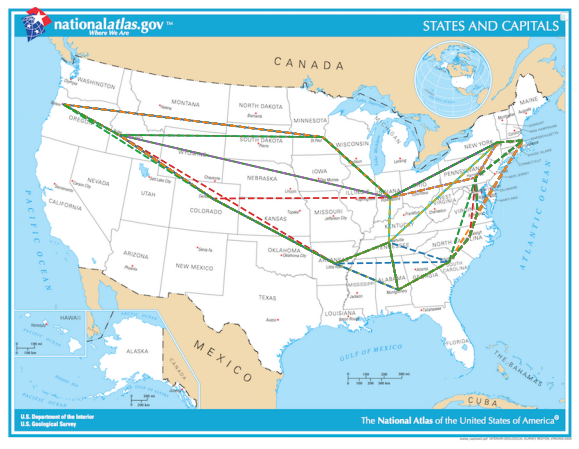

In [14]:
for N in range(8,30+1):
    best = { "ant_count": 0, "min_ants": 0, "path": None, "count": 0 }
    for ant_count in [8,16,32,64,128,256]:
        for min_ants in [64,128,256,512]:
            result = AntColonySolver(ant_count=ant_count, min_ants=min_ants, cost_fn=distance).solve(cities[:N])
            if not best['path'] or best['path'] > path_distance(result):
                best = { "ant_count": ant_count, "min_ants": min_ants, "path": path_distance(result), "count": best['count']+1 }
                continue
            if best['count'] >= 3: 
                best['count'] = 0
                break
    AntColonyRunner(cities[:N], ant_count=best['ant_count'], min_ants=best['min_ants'],plot=True)

### Minumum ve Maximumum karınca sayılarının herbiri üzerinde deneyerek dönüş ve karınca sayılarını hesaplattırdık

# Karıncanın Seyahat Boyunca Attığı Adım Sayısı 
> |ant_speed

Artan `ant_speed` seyehat döngüsü başına atılan adımların sayısını etkiler
- Seyehat döngülerinin sayısını azalttığı için küçük bir performans optimizasyonu sağlar
-`ant_speed` in etkisi, sayısal vectorization kullanmadığında çok daha belirgindir
    - Algoritma doğruluğu için numpy uygulaması varsayılan olarak `1` olarak ayarlanır
-`ant_speed` çok yükseğe ayarlanmışsa, karıncalar herhangi bir seyahat süresi olmaksızın etkili bir şekilde şehirden şehre atlarlar.
- Bu, teoride algoritmayı biraz bozar, ancak yol maliyetleri üzerindeki etki, istatistiksel varyasyon için gürültü seviyeleri dahilindedir.
   
- `ant_speed = 0` ayarlandığında, otomatik olarak optimize edilmiş bir değer denenir:` düğümler arasındaki medyan mesafe // 5` olur

Sehir_Sayısı=14  |  3868 -> 1642 |   10s | Karıncalar: 23060 | Seyahatler:  364 | ant_speed=1 time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 30343 | Seyahatler:  477 | ant_speed=2 time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 38327 | Seyahatler:  605 | ant_speed=4 time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 46083 | Seyahatler:  724 | ant_speed=8 time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 46796 | Seyahatler:  734 | ant_speed=16 time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 53710 | Seyahatler:  848 | ant_speed=32 time=10
Sehir_Sayısı=14  |  3868 -> 1620 |   10s | Karıncalar: 53918 | Seyahatler:  845 | ant_speed=64 time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 54877 | Seyahatler:  862 | ant_speed=128 time=10
Sehir_Sayısı=14  |  3868 -> 1640 |   10s | Karıncalar: 57173 | Seyahatler:  896 | ant_speed=256 time=10
Sehir_Sayısı=14  |  3868 -> 1618 |   10s | Karıncalar: 56744 | Seyahatler: 

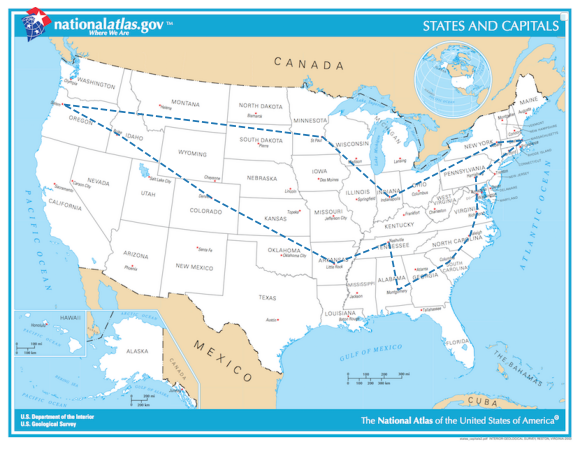

In [15]:
for ant_speed in list(range(0,10+1)):
    result = AntColonyRunner(cities, ant_speed=2**ant_speed, time=10)
result = AntColonyRunner(cities, ant_speed=0, time=10,plot=True)    

# Mesafenin Feromonları Etkileme Gücü:

> |distance_power

Karıncanın feromon izini körü körüne koklamak yerine bir sonraki düğüm seçerken mesafeyi görme yeteneğini etkiler. Bu, performans ve çalışma zamanları üzerinde büyük bir etkiye sahip olabilir.

- `-1` veya negatif mesafe karıncaları önce daha uzak düğümlere gitmeye teşvik eder.
   - Bu buluntular rastgele sonuçlardan daha kötü olabilmektedir.
   - Karıncalar, eve dönen ilk karıncadan daha iyi bir çözüm bulabilir veya bulmayabilir.
- `0` Bu mesafe, ölçüsünü devre dışı bırakır ve tamamen feromon izine dayanır (Eğitilmemiş karıncalar gibi)
   - Bu yakınsama için çok yavaş olabilir
   - Bazen erken sonlandırma sorunlarıyla karşılaşır (yeni en iyi yolları yeterince hızlı bulamamak)
- `1` Bu değer gayet iyi çalışmaktadır,ama grafikleri yakın aralıklı düğüm kümeleri etrafında karışık döngüler oluşturur
- `1.5 - 2.0` Bu çok daha hızlı bir şekilde birleşir ve daha temiz, daha dairesel grafikler üretir (varsayılan = 2)
- `3+` Bu değer daha az keşif ile biraz hızlı bir şekilde birleşir ve optimal olmayan rotaları bulur
- `10` bu biraz (suboptimal) standart altı çözümüdür, ancak tek başına mesafeye bağlı olarak çok hızlı bir şekilde birleşir

Sehir_Sayısı=14  |  3868 -> 3539 |    0s | Karıncalar:   577 | Seyahatler:   10 | distance_power=-2.0 timeout=60
Sehir_Sayısı=14  |  3868 -> 3254 |    0s | Karıncalar:   577 | Seyahatler:   10 | distance_power=-1.0 timeout=60
Sehir_Sayısı=14  |  3868 -> 2208 |    0s | Karıncalar:   534 | Seyahatler:   10 | distance_power=0.0 timeout=60
Sehir_Sayısı=14  |  3868 -> 1626 |    0s | Karıncalar:   610 | Seyahatler:   11 | distance_power=0.5 timeout=60
Sehir_Sayısı=14  |  3868 -> 1626 |    1s | Karıncalar:  1557 | Seyahatler:   26 | distance_power=1.0 timeout=60
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   532 | Seyahatler:   10 | distance_power=1.25 timeout=60
Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:   893 | Seyahatler:   15 | distance_power=1.5 timeout=60
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   939 | Seyahatler:   16 | distance_power=1.75 timeout=60
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   560 | Seyahatler:   10 | distance_power=2.0

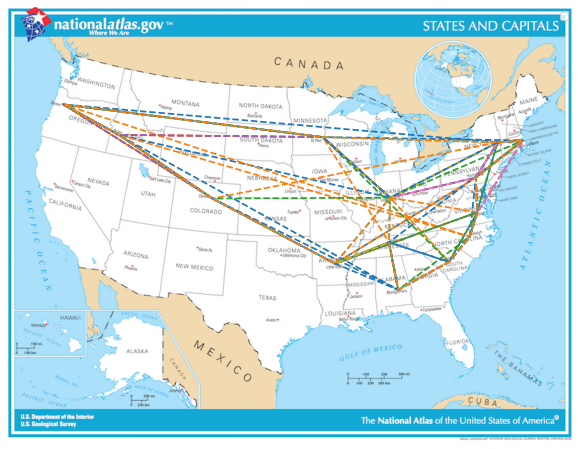

In [16]:
for distance_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, distance_power=distance_power, timeout=60,plot=True)

# Feromonlardaki Farklılıkların Fark Edilme Gücü
> | pheromone_power
Karıncaların feromonlardaki küçük farklılıklardan ne kadar güçlü etkilendiğini belirtir

- Negatif sayılar feromonları belirsiz yapar, ancak algoritma hala rastgele sonuçlardan (biraz) daha iyi bulur
- Karıncalar tarafından mesafe sezgisel devre dışı bırakıldığında feromon güç etkisi en belirgindir.
- Zamanlayıcı olmadan çalıştırıldığında, 1'in biraz üzerinde bir artış, önemli ölçüde genişletilmiş bir çalışma zamanı ile büyük bir path_length iyileştirmesine neden oldu.
- Optimum nokta '1.25' civarında görünüyor (bunu varsayılan olarak ayarlıyor)
    - Bu, feromonlara karşı artan bir duyarlılığı ve karıncaların sürekli olarak yeni yollar bulabileceğini gösterir.
    - Diğer yandan koku ve sezgisel ayarlarının etkisini artıracağı tahmin ediliyor
    - `pheromone_power` Ayarı optimizasyon ve keşif arasındaki ince dengeyi yok edebilir.

Sehir_Sayısı=14  |  3868 -> 2079 |    0s | Karıncalar:   561 | Seyahatler:   10 | distance_power=0 pheromone_power=-2.0 time=0
Sehir_Sayısı=14  |  3868 -> 2522 |    0s | Karıncalar:   546 | Seyahatler:   10 | distance_power=0 pheromone_power=-1.0 time=0
Sehir_Sayısı=14  |  3868 -> 2233 |    0s | Karıncalar:   550 | Seyahatler:   10 | distance_power=0 pheromone_power=0.0 time=0
Sehir_Sayısı=14  |  3868 -> 2283 |    0s | Karıncalar:   538 | Seyahatler:   10 | distance_power=0 pheromone_power=0.5 time=0
Sehir_Sayısı=14  |  3868 -> 1697 |    1s | Karıncalar:  2350 | Seyahatler:   38 | distance_power=0 pheromone_power=1.0 time=0
Sehir_Sayısı=14  |  3868 -> 1766 |    3s | Karıncalar:  5925 | Seyahatler:   95 | distance_power=0 pheromone_power=1.25 time=0
Sehir_Sayısı=14  |  3868 -> 1834 |    1s | Karıncalar:  1398 | Seyahatler:   23 | distance_power=0 pheromone_power=1.5 time=0
Sehir_Sayısı=14  |  3868 -> 1803 |    1s | Karıncalar:  1129 | Seyahatler:   18 | distance_power=0 pheromone_power=

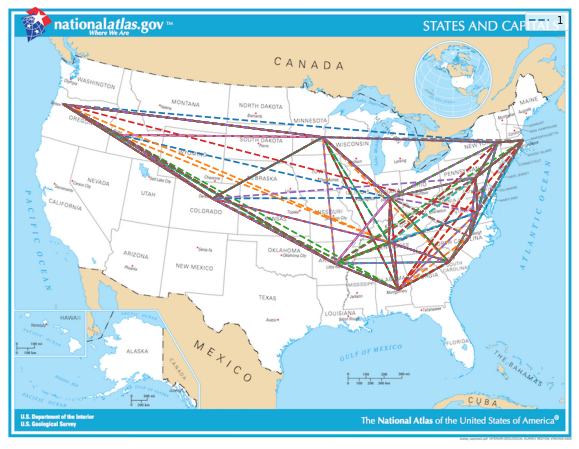

In [17]:
for distance_power in [0,1,2]:
    for pheromone_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0,plot=True)
        plt.legend('1')
    print()

Sehir_Sayısı=14  |  3868 -> 1720 |    2s | Karıncalar:  3296 | Seyahatler:   53 | distance_power=0 pheromone_power=1.0 time=0
Sehir_Sayısı=14  |  3868 -> 1770 |    2s | Karıncalar:  3521 | Seyahatler:   56 | distance_power=0 pheromone_power=1.1 time=0
Sehir_Sayısı=14  |  3868 -> 1800 |    3s | Karıncalar:  4662 | Seyahatler:   74 | distance_power=0 pheromone_power=1.2 time=0
Sehir_Sayısı=14  |  3868 -> 2080 |    0s | Karıncalar:   542 | Seyahatler:   10 | distance_power=0 pheromone_power=1.3 time=0
Sehir_Sayısı=14  |  3868 -> 1727 |    1s | Karıncalar:  2022 | Seyahatler:   33 | distance_power=0 pheromone_power=1.4 time=0

Sehir_Sayısı=14  |  3868 -> 1618 |    0s | Karıncalar:   756 | Seyahatler:   13 | distance_power=1 pheromone_power=1.0 time=0
Sehir_Sayısı=14  |  3868 -> 1640 |    1s | Karıncalar:  1296 | Seyahatler:   22 | distance_power=1 pheromone_power=1.1 time=0
Sehir_Sayısı=14  |  3868 -> 1618 |    1s | Karıncalar:  1037 | Seyahatler:   17 | distance_power=1 pheromone_power=1.

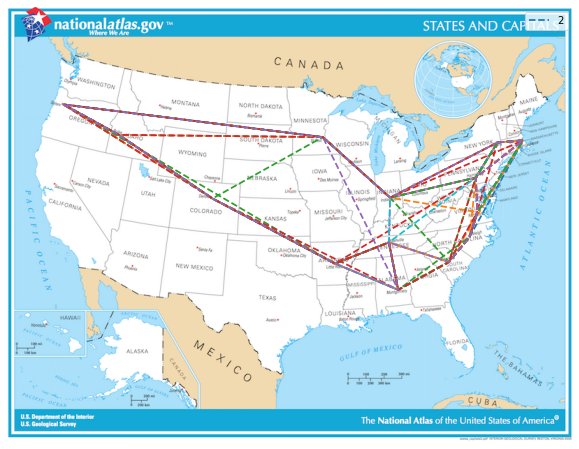

In [18]:
for distance_power in [0,1,2]:
    for pheromone_power in [1.0, 1.1, 1.2, 1.3, 1.4]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0,plot=True)
        plt.legend('2')
    print()

# Feromonların Çürüme Hızı
> |decay_power

Feromonlar ne kadar hızlı çürür?
```
Hesaplama = (self.round_trips ** self.decay_power) * ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
```
- Değeri için `pheromone_power=1.0` 
    - Gürültülü olacağı tahnin ediliyor
- Değeri için `pheromone_power=1.25`
    - Sonuçları yeniden çalıştırırken hala çok fazla varyasyon oluşmaktadır.
    - Değeri için `distance_power=0`: `0` Optimum nokta mı?
    - Değeri için `distance_power=1`: `0`-`1.25` Optimum nokta mı?
    - Değeri için `distance_power=2`: 
         - Önceki optimum noktalar: `0`, `1.25`, `2`
         - Her değerde de gürültülü olacaktır.
         
Algoritma için varsayılan değer: `0`

Sehir_Sayısı=14  |  3868 -> 1620 |   15s | Karıncalar: 27750 | Seyahatler:  440 | pheromone_power=1.0 distance_power=0 decay_power=-1.0 time=15
Sehir_Sayısı=14  |  3868 -> 1667 |   15s | Karıncalar: 32347 | Seyahatler:  510 | pheromone_power=1.0 distance_power=0 decay_power=0.0 time=15
Sehir_Sayısı=14  |  3868 -> 1914 |   15s | Karıncalar: 22125 | Seyahatler:  350 | pheromone_power=1.0 distance_power=0 decay_power=1.0 time=15
Sehir_Sayısı=14  |  3868 -> 1628 |   15s | Karıncalar: 24757 | Seyahatler:  394 | pheromone_power=1.0 distance_power=0 decay_power=1.25 time=15
Sehir_Sayısı=14  |  3868 -> 1676 |   15s | Karıncalar: 28630 | Seyahatler:  455 | pheromone_power=1.0 distance_power=0 decay_power=1.5 time=15
Sehir_Sayısı=14  |  3868 -> 1618 |   15s | Karıncalar: 26049 | Seyahatler:  414 | pheromone_power=1.0 distance_power=0 decay_power=2.0 time=15
Sehir_Sayısı=14  |  3868 -> 1692 |   15s | Karıncalar: 24017 | Seyahatler:  380 | pheromone_power=1.0 distance_power=0 decay_power=3.0 time=

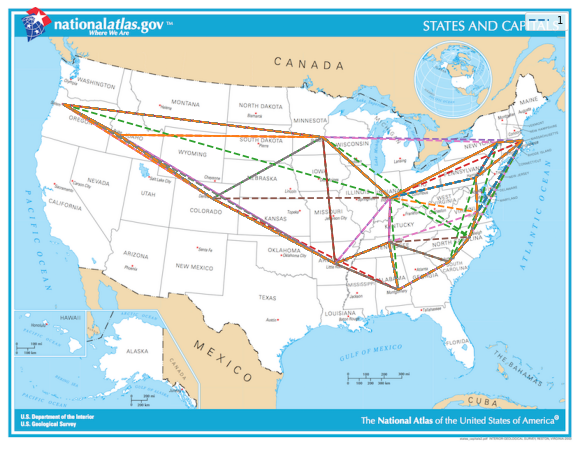

In [19]:
for pheromone_power in [1.0, 1.25]:
    for distance_power in [0,1,2]:
        for decay_power in [-1.0, 0.0, 1.0, 1.25, 1.5, 2.0, 3.0]:
            result = AntColonyRunner(cities, pheromone_power=pheromone_power, distance_power=distance_power, decay_power=decay_power, time=15,plot=True)
            plt.legend('1')
        print()
    print()

Sehir_Sayısı=14  |  3868 -> 1913 |    0s | Karıncalar:   529 | Seyahatler:   10 | distance_power=0 decay_power=-2.0 time=0
Sehir_Sayısı=14  |  3868 -> 1906 |    1s | Karıncalar:  1435 | Seyahatler:   24 | distance_power=0 decay_power=-1.0 time=0
Sehir_Sayısı=14  |  3868 -> 1966 |    0s | Karıncalar:   652 | Seyahatler:   11 | distance_power=0 decay_power=0.0 time=0
Sehir_Sayısı=14  |  3868 -> 2210 |    0s | Karıncalar:   557 | Seyahatler:   10 | distance_power=0 decay_power=0.5 time=0
Sehir_Sayısı=14  |  3868 -> 1678 |    2s | Karıncalar:  3332 | Seyahatler:   54 | distance_power=0 decay_power=1.0 time=0
Sehir_Sayısı=14  |  3868 -> 1716 |    2s | Karıncalar:  3065 | Seyahatler:   50 | distance_power=0 decay_power=1.25 time=0
Sehir_Sayısı=14  |  3868 -> 1771 |    1s | Karıncalar:  1616 | Seyahatler:   26 | distance_power=0 decay_power=1.5 time=0
Sehir_Sayısı=14  |  3868 -> 1642 |    2s | Karıncalar:  3887 | Seyahatler:   63 | distance_power=0 decay_power=2.0 time=0
Sehir_Sayısı=14  |  3

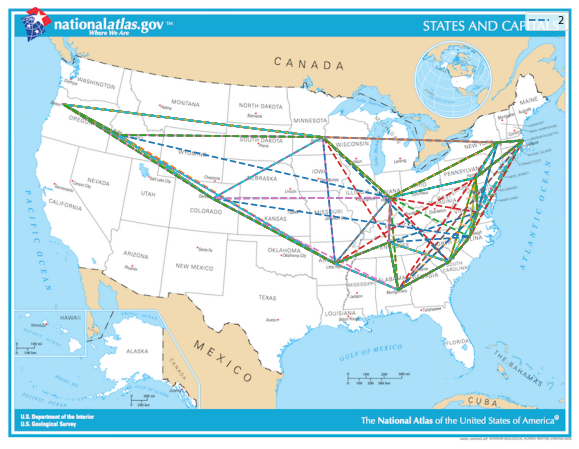

In [20]:
for distance_power in [0,1,2]:
    for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, decay_power=decay_power, time=0,plot=True)
        plt.legend('2')
    print()

# Yeni Bir En İyi Yol Bulunduğunda Kraliçenin Kullandığı Feromonların Artırılması
Bu, kraliçenin yeni bir en iyi yol bulması için verdiği ödüldür ve daha fazla karıncayı bu yeni rotayı keşfetmeye teşvik eder.
> |best_path_smell
- Kısa çalışma süreleri üzerinde daha az etkiye sahiptir
- `best_path_smell == -1` 
    - with `pheromone_power=1`:Karıncaların negatif feromonla karşılaştıklarında rastgele yönlere gitmelerine neden olur
    - with `pheromone_power=1.25`:  Karşılaştırma nedeniyle bir istisna atar: float > complex ≤-1 numbers
- `best_path_smell < 1` Karıncalara en iyi yolu keşfetmeyi bırakmalarını etkili bir şekilde söyler.
- `best_path_smell == 1` Bu değer işlevselliği kaldırır,ancak karıncalar hala makul bir yol bulur
- `best_path_smell > 1` Karıncaların sürekli olarak daha iyi yollar bulma ve çabuk pes etmeme yeteneklerini geliştirir
    - Çalışması için 1'in üzerinde olması gerekmez (karıncaların hepsi birbirini takip eder ve bir geri bildirim döngüsü oluşturur)
    - Daha yüksek değerler ek etki yaratmaz
    - Çok yüksek (5+) ayarlanması, karıncaların komşu rotaları keşfetmesini önlediği için bu etkiyi geri alır
- `best_path_smell > 2` 
    - Bu değer sezgisel en etkili olması için gereklidir `distance_power=0` `  
    - Varsayılan değer = `2`

Sehir_Sayısı=14  |  3868 -> 2179 |   15s | Karıncalar: 23227 | Seyahatler:  367 | distance_power=0 best_path_smell=0.5 time=15
Sehir_Sayısı=14  |  3868 -> 1793 |   15s | Karıncalar: 24410 | Seyahatler:  386 | distance_power=0 best_path_smell=1.0 time=15
Sehir_Sayısı=14  |  3868 -> 1698 |   15s | Karıncalar: 28688 | Seyahatler:  456 | distance_power=0 best_path_smell=1.25 time=15
Sehir_Sayısı=14  |  3868 -> 1620 |   15s | Karıncalar: 38145 | Seyahatler:  603 | distance_power=0 best_path_smell=2.0 time=15
Sehir_Sayısı=14  |  3868 -> 1620 |   15s | Karıncalar: 35203 | Seyahatler:  555 | distance_power=0 best_path_smell=3.0 time=15
Sehir_Sayısı=14  |  3868 -> 2132 |   15s | Karıncalar: 30260 | Seyahatler:  473 | distance_power=0 best_path_smell=5.0 time=15

Sehir_Sayısı=14  |  3868 -> 1620 |   15s | Karıncalar: 32199 | Seyahatler:  508 | distance_power=1 best_path_smell=0.5 time=15
Sehir_Sayısı=14  |  3868 -> 1618 |   15s | Karıncalar: 34688 | Seyahatler:  552 | distance_power=1 best_path_

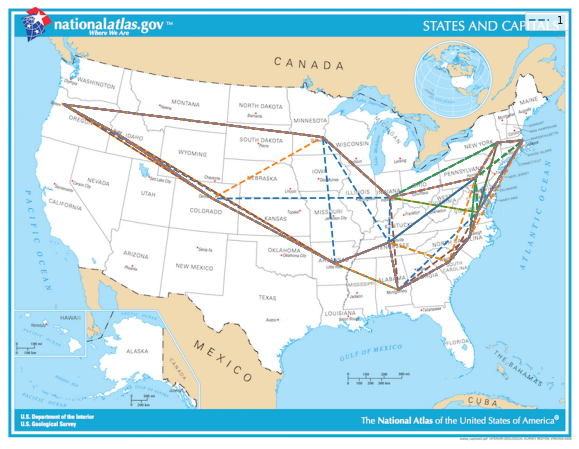

In [21]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.5, 1.0, 1.25, 2.0, 3.0, 5.0,]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, time=15,plot=True)
        plt.legend('1')
    print()

Sehir_Sayısı=14  |  3868 -> 2441 |    1s | Karıncalar:  1189 | Seyahatler:   20 | distance_power=0 best_path_smell=0.5 min_round_trips=20 time=0
Sehir_Sayısı=14  |  3868 -> 2172 |    1s | Karıncalar:  1375 | Seyahatler:   23 | distance_power=0 best_path_smell=1.0 min_round_trips=20 time=0
Sehir_Sayısı=14  |  3868 -> 2141 |    1s | Karıncalar:  2293 | Seyahatler:   38 | distance_power=0 best_path_smell=1.25 min_round_trips=20 time=0
Sehir_Sayısı=14  |  3868 -> 1758 |    1s | Karıncalar:  1301 | Seyahatler:   22 | distance_power=0 best_path_smell=2.0 min_round_trips=20 time=0
Sehir_Sayısı=14  |  3868 -> 1678 |    1s | Karıncalar:  1173 | Seyahatler:   20 | distance_power=0 best_path_smell=3.0 min_round_trips=20 time=0
Sehir_Sayısı=14  |  3868 -> 1961 |    1s | Karıncalar:  1696 | Seyahatler:   27 | distance_power=0 best_path_smell=5.0 min_round_trips=20 time=0

Sehir_Sayısı=14  |  3868 -> 1717 |    1s | Karıncalar:  1412 | Seyahatler:   24 | distance_power=1 best_path_smell=0.5 min_round

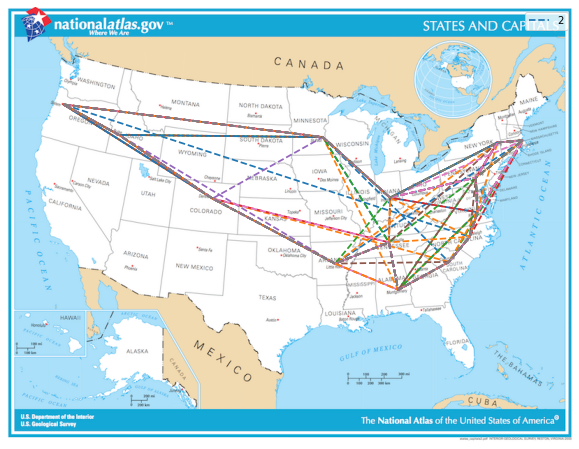

In [22]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.5, 1.0, 1.25, 2.0, 3.0, 5.0,]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, min_round_trips=20, time=0,plot=True)
        plt.legend('2')
    print()

# Başlangıc Feromonların Miktarı
> |start_smell

Bu, aramanın başlangıcında haritadaki feromon miktarını etkiler. Yüksek değerler, erken keşifte daha fazla rastgeleliği teşvik eder.
- Bunun etkileri, daha düşük bir "self.distance_power" ile daha belirgindir.
- "start_smell" çok düşükse, karıncalar ilk ideal olmayan yolda hızla birleşirler, sonra kendilerini düzeltmeleri daha uzun sürer
- "start_smell" çok yüksekse, karıncaların bıraktığı feromonların "start_smell" i alt etmesi uzun zaman alacaktır.
     - Bu aynı zamanda, rastgele dolaşan karıncaların bıraktığı feromon izini de bozarak, optimal olmayan yollara yol açabilir.
- "start_smell" çok yüksekse, bu, feromon haritasını tamamen etkisiz hale getirir ve karıncaları yalnızca mesafe ölçüsüne güvenmeye bırakır.
- "start_smell" tam olarak doğruysa, karıncalar optimizasyon ve keşif arasında iyi bir dengeye sahip olacak ve hızla yakınlaşacaktır.
- `start_smell=0` varsayılan ayarı `10**self.distance_power`

Sehir_Sayısı=14  |  3868 -> 1627 |   15s | Karıncalar: 31891 | Seyahatler:  504 | distance_power=0 start_smell=1 time=15
Sehir_Sayısı=14  |  3868 -> 1620 |   15s | Karıncalar: 34753 | Seyahatler:  546 | distance_power=0 start_smell=5 time=15
Sehir_Sayısı=14  |  3868 -> 1724 |   15s | Karıncalar: 31859 | Seyahatler:  502 | distance_power=0 start_smell=25 time=15
Sehir_Sayısı=14  |  3868 -> 1693 |   15s | Karıncalar: 32622 | Seyahatler:  513 | distance_power=0 start_smell=125 time=15
Sehir_Sayısı=14  |  3868 -> 1701 |   15s | Karıncalar: 30965 | Seyahatler:  490 | distance_power=0 start_smell=625 time=15
Sehir_Sayısı=14  |  3868 -> 1692 |   15s | Karıncalar: 33490 | Seyahatler:  530 | distance_power=0 start_smell=3125 time=15
Sehir_Sayısı=14  |  3868 -> 1676 |   15s | Karıncalar: 32980 | Seyahatler:  522 | distance_power=0 start_smell=15625 time=15
Sehir_Sayısı=14  |  3868 -> 1642 |   15s | Karıncalar: 31604 | Seyahatler:  500 | distance_power=0 start_smell=78125 time=15
Sehir_Sayısı=14 

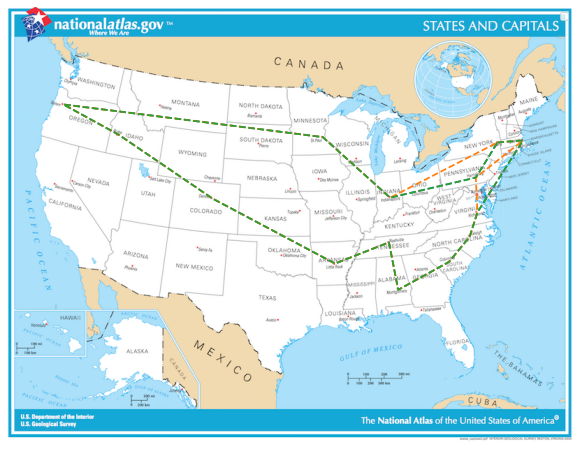

In [23]:
for distance_power in [0, 1, 2]:
    for start_smell in list(range(0,8)):
        result = AntColonyRunner(cities, distance_power=distance_power, start_smell=5**start_smell, time=15)
    result = AntColonyRunner(cities, distance_power=distance_power, start_smell=0, time=15,plot=True)
    print()

# Yeni En İyi Yoldan Sonra Çaba Tekrarı:
> |stop_factor

Pes etmeden önce yeni bir en iyi yol bulduktan sonra karıncaların çabalarını kaç kez ikiye katlayacaklarını kontrol eder..

- Daha iyi yollar için aşırı çalıştırma sürelerine karşı erken sonlandırma riskidi yüksektir.
- "1.5" Çok küçüktür ve genellikle erken sonlandırmayla sonuçlanır
- "2" yakınsamaya ulaşmak için doğru optimum nokta olduğu düşünülmektedir.
- "5 +", önemli ölçüde daha iyi çözümler üretmeden CPU döngülerini aşırı yorar

Sehir_Sayısı=14  |  3868 -> 2155 |    0s | Karıncalar:   537 | Seyahatler:   10 | distance_power=0 stop_factor=1.5
Sehir_Sayısı=14  |  3868 -> 1807 |    1s | Karıncalar:  1095 | Seyahatler:   19 | distance_power=0 stop_factor=1.75
Sehir_Sayısı=14  |  3868 -> 1726 |    3s | Karıncalar:  5600 | Seyahatler:   89 | distance_power=0 stop_factor=2

Sehir_Sayısı=14  |  3868 -> 1640 |    0s | Karıncalar:   530 | Seyahatler:   10 | distance_power=1 stop_factor=1.5
Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   537 | Seyahatler:   10 | distance_power=1 stop_factor=1.75
Sehir_Sayısı=14  |  3868 -> 1668 |    1s | Karıncalar:  1305 | Seyahatler:   22 | distance_power=1 stop_factor=2

Sehir_Sayısı=14  |  3868 -> 1620 |    0s | Karıncalar:   559 | Seyahatler:   10 | distance_power=2 stop_factor=1.5
Sehir_Sayısı=14  |  3868 -> 1642 |    0s | Karıncalar:   747 | Seyahatler:   13 | distance_power=2 stop_factor=1.75
Sehir_Sayısı=14  |  3868 -> 1642 |    0s | Karıncalar:   543 | Seyahatler:   10

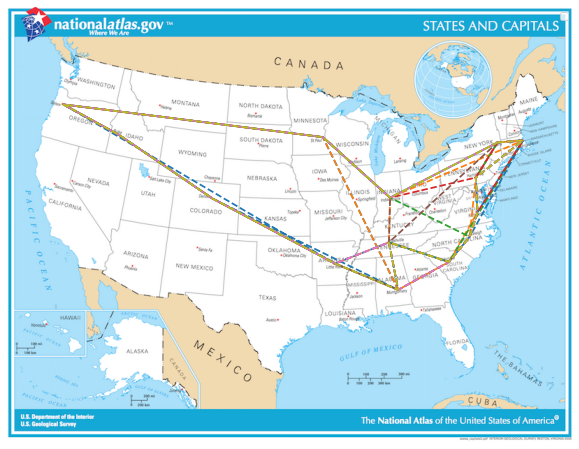

In [24]:
for distance_power in [0, 1, 2]:
    for stop_factor in [1.5, 1.75, 2]:
        result = AntColonyRunner(cities, distance_power=distance_power, stop_factor=stop_factor,plot=True)
    print()